<a href="https://colab.research.google.com/github/menotti/pp/blob/master/tutorials/Vetoriza%C3%A7%C3%A3o_SSE_%26_AVX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vetorização SSE & AVX

In [7]:
!git clone https://github.com/menotti/playground-41d1904q
!cat playground-41d1904q/techio.yml

Cloning into 'playground-41d1904q'...
remote: Enumerating objects: 704, done.
remote: Counting objects: 100% (704/704), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 704 (delta 375), reused 600 (delta 311), pack-reused 0
Receiving objects: 100% (704/704), 1005.31 KiB | 5.62 MiB/s, done.
Resolving deltas: 100% (375/375), done.
title : "Vetorização SSE & AVX "
cover: /images/cover.png
plan:
  - title: "O que é SSE e AVX?"
    statement: markdowns/intro.md
  - title: "Pré-requisitos"
    statement: markdowns/prereq.md
  - title: "Autovetorização"
    statement: markdowns/autovector.md
  - title: "Uso de SSE e AVX"
    statement: markdowns/usage.md
  - title: "Primeiro código AVX: cálculo SQRT"
    statement: markdowns/sqrt.md
  - title: "Frameworks C++ SSE/AVX"
    statement: markdowns/frameworks.md
  - title: "Mascaramento e carga condicional"
    statement: markdowns/masking.md
  - title: "Controlando o fluxo de dados"
    statement: markdowns/dataflow.md
  - ti

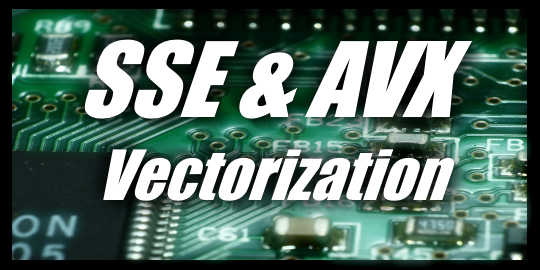

## O que é SSE e AVX? 

###História
Nos anos recentes, as CPUs alcançaram algumas limitações físicas e de energia, logo as velocidades de CPU não cresceram expressivamente, em termos de GHz. Conforme necessidades computacionais continuaram a crescer, projetistas de CPU decidiram resolver este problema com três soluções:

*   Adicionando mais núcleos. Desse modo, os Sistemas Operacionais podem distribuir aplicações em execução através dos diferentes núcleos. Além disso, programas podem criar múltiplas threads a fim de maximizar a utilização dos núcleos.
*   Adicionando operações vetoriais a cada núcleo. Esta solução permite com que o processador execute uma mesma instrução a todo um vetor de dados. Isto só pode ser feito a nível de aplicação.
*   Execução fora de ordem de múltiplas instruções. CPUs modernas são capazes de executar até quatro instruções ao mesmo tempo, se elas forem independentes. Leia http://www.agner.org/optimize/blog/read.php?i=417 para mais informações



Registradores vetoriais começaram em 1997 com o conjunto de instruções MMX, contendo registradores de 80-bit. Mais tarde, os conjuntos de instruções SSE foram lançados (diversas versões deles, do SSE1 ao SSE4.2), com registradores de 128-bits. Em 2011, a Intel lançou a arquitetura Sandy Bridge, com o conjunto de instruções AVX (registradores de 256-bits). Em 2016 o primeiro processador AVX-512 foi lançado, com registradores de 512-bits (até 16x 32-bit vetores de float).

Nesse curso iremos focar em ambos os conjuntos de instrução - SSE e AVX - porque ambos são comumente encontrados em processadores recentes. O AVX-512 está fora do escopo do curso, mas a maior parte do curso pode ser reutilizada, mudando apenas os registradores de 256-bit para as suas contrapartes de 512-bits (registradores ZMM).

###Registradores SSE & AVX
O SSE e AVX têm 16 registradores cada. No SSE estes são referenciados como XMM0-XMM15, e no AVX são chamados YMM0-YMM15. Registradores XMM têm 128 bits de tamanho, enquanto YMM são 256bit.

SSE adiciona três typedefs: **`__m128 , __m128d e __m128i`**. Float, double (d) e integer (i) respectivamente.

AVX adiciona três typedefs: **`__m256 , __m256d e __m256i`** . Float, double (d) e integer (i) respectivamente.

SSE & AVX Registers

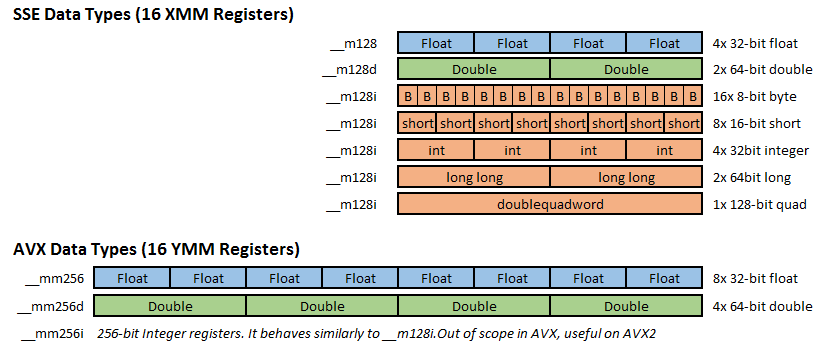


> **NOTE**: Os XMM e YMM se sobrepoem! Os registradores XMM são tratados como a metade inferior do correspondente registrador YMM. Isso pode introduzir alguns problemas de performance ao misturar código SSE e AVX.

Tipos de dado float (__m128, __m128d, __m256 and __m256d) têm apenas uma espécie de estrutura de dados. Por causa disso, o GCC permite o acesso à componentes de dado como um arranjo (array). I.e: Isto é válido:

  

```
__m256 myvar = _mm256_set1_ps(6.665f); //Atribui um único float a todos os valores do vetor
  myvar[0] = 2.22f;                       //Válido em um compilador GCC
  float f = (3.4f + myvar[0]) * myvar[7]; //Isto é válido em um compilador GCC
```



__m128i e __m256i são unions, então os tipos de dados devem ser referenciados. Eu não encontrei uma maneira apropriada de obter a declaração da union, então utilizo funções _mm_extract_epiXX() para obter valores individuais de dados de vetores do tipo integer.

###Exemplo de operação com AVX
Quando uma instrução em AVX é executada, o processo é o seguinte:

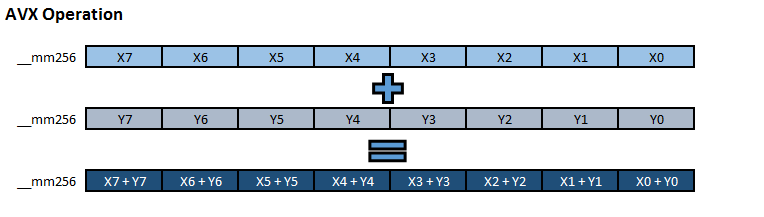

Todas as operações são aplicadas no mesmo instante. Em termos de desempenho, o custo de execução para um único **`Add`** em um float é similar ao de executar **`VAdd`** em 8 floats em AVX. Em http://www.agner.org/optimize/instruction_tables.pdf, você tem maiores informações no que concerne à latência e taxa de transferência das instruções. Na arquitetura Sandy Bridge, **`VADDPS/D`** tem latência 3 and taxa de transferência 1, exatamente como **`FADD(P)`**
1 Este tutorial faz parte de um https://github.com/menotti/pp e traz apenas exemplos de uso. Acesse o material completo para mais detalhes.

##Pré-requisitos

SSE/AVX possuem pré-requisitos na arquitetura da máquina alvo. Nesse curso, as compilações binárias terão como alvo apenas a máquina atual. Para isso, nós usaremos arch=native, uma flag do GCC para detectar os recursos da CPU e usá-los de acordo.

> **Nota**: Binários compilados irão falhar em maquinas que não possuem compatibilidade para AVX. Se você precisa de um binário que se adapte a diferentes CPUs, você precisará fazer uso da identificação da CPU e utilizar funções diferentes, ou fazer diferentes binários destinados para cada conjunto de instruções diferente.


Como dito na introdução, o SO, o compilador e a CPU devem todos suportar extensões AVX. Nós podemos rodar esse script para detectar os recursos do sistema:

@[Detect System Capabilities]({"stubs": ["prereq/detect.sh"], "command": "./run.sh ./prereq/detect.sh"})

Em CPU flag capabilities, nós procuraremos pela flag avx. Isso identifica que a CPU é compatível com AVX. Se você tem avx2 significa que a CPU suporta extensões AVX2. AVX é o suficiente para se ter vetores float de 8x32 bits. AVX2 adiciona vetores para inteiros de 256 bits (números inteiros de 8x32 bits, por exemplo). Mesmo assim, vetores inteiros de 256 bits parecem ser executados da mesma forma que dois vetores de 128 bits, então o desempenho não melhora significativamente em relação aos vetores inteiros SSE de 128 bits.

Em GCC capabilities nós procuraremos pelo pragma #define __AVX__ 1. Isso indica que as branch do AVX serão ativadas.

> Sempre use **-march=native ou -mavx** !! Se você roda o GCC sem elas, você não conseguirá a flag __AVX__!!! Os parâmetros padrões do GCC são genéricos e sem a flag não será possivel ativar o AVX mesmo que a CPU seja compatível.

Por fim, nós verificamos se o Kernel do Linux é 2.6.30 ou maior. Um Kernel 4.4.0 ou maior é o ideal.

Com todos esses pré-requisitos atendidos, nós estamos prontos para programar o nosso primeiro programa vetorizado AVX!

###Autovetorização


###Flags de autovetorização do GCC

O GCC é um compilador com recursos avançados, e, com as flags de otimização -O3 ou -ftree-vectorize, o programador pode indicar ao compilador para que procure por laços e otimize-os (lembre-se de também especificar a flag -mavx). O código fonte continua o mesmo, contudo, o código compilado pelo GCC é completamente diferente.

Por padrão, o GCC não irá indicar se ou onde foi aplicada a autovetorização, exceto que as seguintes flags sejam utilizadas:


*   -fopt-info-vec ou -fopt-info-vec-optimized: O compilador vai informar quais laços (por N° de linha) estão sendo otimizados por vetorização.

*   -fopt-info-vec-missed: Fornece informações detalhadas sobre os laços nos quais não foram otimizados, permitindo ao programador que realize mudanças no código para que tal otimização seja possível.

*   -fopt-info-vec-note: Informações detalhadas sobre todos os laços e otimizações feitas.
-fopt-info-vec-all: Todas as flags anteriores.


> NOTA: Há flags similares para outras otimizações que seguem o formato -fopt-info-[opção]-optimized tal como a otimização inline na qual pode ser indicada com a flag -fopt-info-inline-optimized

Neste exemplo, utilizaremos a otimização de autovetorização do GCC. Para isso, habilite as flags -O3 e com o modo verboso -fopt-info-vec-optimized. Você pode alterar as flags de compilação para ver diferentes opções de saída: @[Autovectorization]({"stubs": ["autovector/autovector.cpp","autovector/compilerflags.txt"], "command": "./mycompileLOG.sh autovector ./autovector"})

Se tudo estiver correto, os resultados dos testes devem ser iguais aos seguintes:

/project/target/autovector/autovector.cpp:22:21: note: loop vectorized

/project/target/autovector/autovector.cpp:15:23: note: loop vectorized

Com o mesmo código fonte, é possível realizar dois testes distintos:

* No arquivo compilerflags.txt, altere as opções de exibição de informações para -fopt-info-vec-all, e execute novamente o exemplo.
* Na primeira linha de do arquivo autovector.cpp, altere optimize("O3", para optimize("O2",, e execute novamente.

Compilações que não utilizam otimizações de vetorização serão mais lentas que as vetorizadas.

###Requisitos para a vetorização de laços

Nem todos os laços podem ser vetorizados. Para que tal otimização seja realizada, existem algumas ressalvas:

* A contagem do laço não pode ser alterada assim que as iterações se iniciarem. Isso significa que o final do laço deve ser previsível, sem a utilização de variáveis dinâmicas para esse controle, isto é, alterarem-se sem comportamento previsível, aleatoriamente crescendo ou descrescendo.
* O uso das palavras chave break ou continue também impõem limitações. Algumas vezes o compilador é inteligente o suficiente para aplicar a otimização mesmo com o uso delas, mas este não é sempre o caso. Tente adicionar a linha if (j == 27) continue; logo antes da atribuição result[j] na linha 25, e execute novamente a compilação.
* Há alguns limites na realização de chamadas de funções externas dentro do laço.
* Não deve haver dependência de dados com outros índices do laço. Por exemplo, for (int i = 1; i < N; i++) x[i] = x[i - 1] * 2;, neste caso, o laço é percorrido com a variável i, e o dado na posição x[i] depende no valor resultante anterior x[i - 1]. De modo que os registradores AVX são carregados utilizando 8 valores de ponto flutuante, o compilador não consegue fazer tal operação de forma otimizada.
* Comandos condicionais (if / else) podem ser utilizados desde que não alterem o fluxo de controle, e apenas para, por exemplo, condicionamente carregar os valores A ou B na variável C. Para selecionar os valores A ou B o compilador aplica o uso de máscaras, de modo que ambos os caminhos de dados A e B são calculados, e C vai carregar um valor ou outro. Por exemplo:

```
if ( s >= 0 ) {
 x[i] = (-b[i]+s)/(2.0f*a[i]);
 y[i] = (-b[i]-s)/(2.0f*a[i]);
}
else {
 x[i] = 0.0f;
 y[i] = 0.0f;
```

Este é um laço vetorizável. Note que o fluxo de controle nunca é alterado, e as posições x[i] e y[i] são sempre definidas para um ou outro valor.

Leia https://software.intel.com/sites/default/files/m/4/8/8/2/a/31848-CompilerAutovectorizationGuide.pdf
 para informações adicionais sobre autovetorização. Este documento refere-se a compiladores da Intel, mas fornece informações completas e interessantes sobre o assunto. Também é possível encontrar informações na página https://gcc.gnu.org/projects/tree-ssa/vectorization.html do compilador GCC.


Um detalhe interessante sobre autovetorização é que ela vem de graça. O programador não precisa realizar mudanças drásticas no código, e possivelmente o laço será vetorizado. Algumas vezes, especialmente em computações de alto desempenho, os laços e a vetorização precisam ser otimizados manualmente para utilizar os registradores AVX, garantindo maior vazão. Tal tópico será explorado nas próximas lições.

##Uso de SSE e AVX


CPU's com SSE/AVX têm instruções assembly para operar com registradores XMM e YMM. Mas, na maioria dos compiladores o processo é simplificado usando funções intrínsecas, para que programadores não precisem usar assembly diretamente.

###Funções intrínsecas

Compiladores encapsulam instruções assembly como funções, e usá-las é tão fácil quanto chamar uma função com os parâmetros corretos. Ás vezes essas funções intrínsecas são emuladas se a CPU não suportar o conjunto de instruções.

Funções intrínsecas de SSE/AVX usam a seguinte convenção de nomenclatura:

```
 _<vector_size>_<intrin_op>_<suffix>
```

* **`< vector_size >`** é **`mm`** para vetores 128 bit (SSE), **`mm256`**  para vetores 256 bit (AVX e AVX2), e **`mm512`**  para AVX512.
* **`< intrin_op >`** Declara a  da função intrínseca. I.e. **`add, sub, mul`**, etc...
* **`< suffix >`** Indica o tipo de dado. **`ps`** para float, **`pd`**  para double, e **`ep< int_type >`** é para tipos de dado inteiro **`epi32`** para inteiro de 32 bit com sinal, **`epu16`**  para inteiro de 16 bit sem sinal, etc..

Você pode encontrar todas as funções intrínsecas no https://software.intel.com/sites/landingpage/IntrinsicsGuide É uma referência completa para qualquer função intrínseca disponível em SSE/AVX, com categorias e barra de pesquisa. Há também a https://db.in.tum.de/~finis/x86-intrin-cheatsheet-v2.2.pdf?lang=en  Mas é mais complicada de ler porque é mais complexa.

###Funções ausentes nas intrínsecas SSE/AVX
**Ausência de divisão inteira**

Por alguma razão, SSE e AVX não possuem operadores de divisão inteira. Existem algumas maneiras de contornar isso:

* Calculando a divisão em código linear. Recuperando os dados únicos, dividindo-os e armazenando-os novamente no vetor. Isso é bem lento.
* Convertendo o vetor de inteiro para float, dividindo-o e convertendo-o novamente para inteiro.
* Para divisores conhecidos em tempo de compilação, existem alguns números mágicos para converter uma divisão por uma constante em uma operação de multiplicação. Veja https://libdivide.com/  e http://www.icodeguru.com/Embedded/Hacker's-Delight/077.htm  para mais informações.
* Para divisões por potências de dois, usando a operação de deslocamento de bits. Dividir pelo inteiro 2 é a mesma coisa que efetuar um deslocamento à direita. Isso pode ser feito apenas se todos os vetores forem divididos pela mesma potência de dois. Preste atenção quando efetuar um deslocamento à direita em números com sinal! Use operações de deslocamento de bits que reconheçam o sinal.

**Ausência de funções trigonométricas**

Não existem funções trigonométricos em funções intrínsecas de vetor. Soluções possíveis são calculá-las com código linear (uma a uma para cada valor do vetor), ou criar funções de aproximação. As aproximações de Séries de Taylor e Remez dão bons resultados.

**Ausência de um gerador de números aleatórios**

Além disso, não existem geradores de números aleatórios para vetores como intrínsecos. Mas é simples recriar um bom gerador pseudoaleatório a partir de uma versão linear. Apenas certifique-se dos bits usados no gerador de números pseudoaleatórios. Geradores de 32 ou 64 bits são preferíveis para preencher vetores.

###Penalidades de desempenho
**Alinhamento de dados**

Arquiteturas de CPU mais antigas não podem usar vetorização à menos que os dados estejam alinhadas em memória ao tamanho do vetor. Algumas outras CPUs podem usar dados não alinhados com algumas penalidades de desempenho. Nos processadores recentes a penalidade parece ser insignificante http://lemire.me/blog/2012/05/31/data-alignment-for-speed-myth-or-reality/. Mas, para garantir, pode ser uma boa ideia alinhar os dados se isso não adicionar uma sobrecarga excessiva.

No GCC, o alinhamento de dados pode ser feito com esses atributos de variável: **`__attribute__((aligned(16))) __attribute__((aligned(32)))`**

Reveja https://gcc.gnu.org/onlinedocs/gcc-3.2/gcc/Variable-Attributes.html para mais informações.

Eu faço apenas: **`#define ALIGN __attribute__((aligned(32)))`** para simplificar a declaração de alinhamento em variáveis.

**Penalidades de transição SSE <-> AVX**

Há outro grande problema ao misturar bibliotecas legadas SSE e a nova arquitetura AVX. Como o XMM e o YMM compartilham os 128 bits inferiores, transicionar entre AVX e SSE pode levar a valores indefinidos nos 128 bits superiores. Para resolver isso, o compilador precisa salvar os 128 bits inferiores, limpá-los, executar a operação SSE antiga e restaurar o valor antigo. Isso adiciona uma sobrecarga perceptível às operações do AVX, resultando em desempenho reduzido.

> NOTA: Esse problema NÃO SIGNIFICA que você não pode usar __m128 and __m256 ao mesmo tempo sem penalidades de desempenho. AVX tem um novo conjunto de instruções para __m128, com prefixos VEX. Essas novas instruções VEX não têm nenhum problema em combinar com instruções __m256. A penalidade de transição ocorre quando instruções __m128 não-VEX são combinadas com instruções __m256. Isso acontece quando você usa bibliotecas SSE antigas ligadas à programas AVX novos.

Para evitar penalidades de transição, o compilador pode adicionar automaticamente chamadas para VZEROUPPER (limpa os 128 bits superiores) ou VZEROALL (limpa todo o registrador YMM) com o parâmetro -mvzeroupper, ou o programador pode fazê-lo manualmente. Se você não estiver usando nenhuma biblioteca SSE externa, e tiver certeza de que tudo que você programa é habilitado para VEX e compilado com extensões AVX habilitadas, você pode instruir o compilador a evitar adicionar chamadas VZEROUPPER, com: -mno-vzeroupper

Confira https://stackoverflow.com/questions/41303780/why-is-this-sse-code-6-times-slower-without-vzeroupper-on-skylake para informações adicionais.

**Carregamento, descarregamento e embaralhamento de dados**

Mover dados dos registradores AVX pra lá e pra cá pode ser custoso. Em alguns casos, se você tem alguns dados armazenados em estruturas lineares, enviar esses dados para vetores AVX, executar algumas operações e recuperar esses dados pode ser mais custoso que simplesmente realizar os cálculos linearmente.

Algum tempo atrás, eu tentei simular um pouco de física em um jogo, Codingame's https://www.codingame.com/multiplayer/bot-programming/poker-chip-race , com AVX. Esse jogo é baseado em N entidades circulares colidindo em um espaço 2D. Então, naquele cenário eu precisava calcular até N*(N-1)/2 possíveis colisões. Minha primeira tentativa envolveu ter classes de entidade normais (com posição, raio, etc) e para o cálculo de colisão eu embaralhei todas as possíveis colisões de entidades em vetores AVX, as calculei em AVX e as retornei de volta para as classes de entidade. Quando terminei, os resultados que obtive foram medíocres, com uma melhoria não superior à 30% em relação ao código linear, com muita sobrecarga e um código difícil de manter. Depois de usar um profiler eu detectei que 90% do tempo de CPU estava sendo usado em carregamento e descarregamento de dados.

Portanto, os programadores devem levar em consideração a sobrecarga de carregamento e descarregamento de dados. Lembre-se de que em alguns casos isso se torna um gargalo.

##Primeiro código AVX: cálculo SQRT

Agora que analisamos todos os requisitos, a autovectorização e as intrínsecas do AVX, podemos criar nosso primeiro programa vetorizado manualmente. Neste exercício, você precisa vetorizar um cálculo sqrt de números de ponto flutuante. Usaremos explicitamente o tipo de dados __m256 para armazenar nossos números de ponto flutuante, reduzindo a sobrecarga no carregamento de dados.

@[Vectorized SQRT]({"stubs": ["sqrt/sqrt.cpp"], "command": "./mycompile.sh sqrt ./sqrt"})

Você provavelmente verá uma melhoria de desempenho de 600% ou mais. Ou seja, depois de carregar os dados, o AVX executará até 7 vezes mais rápido que o sqrtf normal. O limite teórico é de 800%, mas raramente é alcançado. Você pode esperar um aumento médio entre 300% e 600%.

##Frameworks C++ SSE/AVX

###Complexidade de funções intrínsecas

Trabalhar diretamente com funções intrínsecas pode ser complicado de ser codificado e mantido. O problema é que os nomes intrínsecos são longos e as operações aritméticas são escritas na notação de função: add(a,b) ao invés de a+b. O código a seguir é dificil de ler:

```
x = _mm256_div_ps(_mm256_add_ps(b , _mm256_sqrt_ps(_mm256_sub_ps(_mm256_mul_ps(b , b) , _mm256_mul_ps(_mm256_mul_ps(a , c),_mm256_set1_ps(4.0f))))) , _mm256_mul_ps(a,_mm256_set1_ps(2.0f)));
```
Muito simples, correto? Por outro lado, essa versão empacotada é muito legível:

```
x = (b + sqrt( b*b - a*c*4.0f))/(a*2.0f)
```

É como trabalhar com pontos flutuantes (floats). Você apenas precisa se lembrar que essas variáveis são vetores. Como você pode notar, o empacotamento permite operações aritméticas de um vetor com um valor escalar (vetor * escalar = vetor).

###Frameworks C++ para computação SIMD

Existem frameworks que agrupam tipos de dados vetoriais dentro de novas classes. Em seguida, sobrecarregam os operadores aritméticos, lógicos e de atribuição para simplificar os cálculos. Entre outros, você pode usar esses dois frameworks:


1.   http://www.agner.org/optimize/#vectorclass . Completo e atualizado regularmente. Inclui funções trigonométricas.
2.   https://gain-performance.com/ume/. É a biblioteca mais recente. Eu não usei pessoalmente.

###Frameworks de tamanho reduzido

Infelizmente, essas dois frameworks são enormes, pelo menos para programação competitiva onde o código é limitado a cem KBs ou menos. Nos casos em que você tem limitações no tamanho do código, você precisará reduzir para uma versão menor de um desses frameworks.

Eu tenho alguns empacotadores de vetor com tamanho reduzido, focados apenas em um ou dois tipos (por exemplo, __m256 8x float e __m128i 8x short, para trabalhar com um tamanho de vetor de 8, tanto em floats (pontos flutuantes) quanto em números inteiros).

@[Empacotar vetores menores]({"stubs": ["framework/framework.cpp","framework/vrandom.h","framework/vconvert.h","framework/v8i.h","framework/v8f.h"], "command": "./mycompile.sh framework ./framework"})

Mesmo sendo uma versão reduzida, cada declaração de tipo de dados vetorial ocupa até 150 linhas em média (mais algumas funções auxiliares). Por favor, use esses empacotadores como referência para as suas próprias versões, pois elas podem conter bugs.

As classes empacotadas podem adicionar sobrecarga às chamadas, reduzindo o seu desempenho. Mas, na minha opinião, trabalhar diretamente com as funções intrínsecas dificilmente será mantido, além de ser embaraçoso e propenso a erros. A partir de agora, usarei classes empacotadas para abstrair o código dos intrínsecos fundamentais.

Em todas os frameworks vetoriais, você encontrará algumas funções especiais. Essas funções especiais serão amplamente usadas nas lições a seguir. Se você não entender à primeira vista, não se preocupe. Você eventualmente entenderá a lógica por trás deles.

**Funções baseadas em mesclagem**: A mesclagem é o processo de carregar condicionalmente valores vetoriais com base em uma máscara. Isso será explicado melhor nas lições a seguir. Em ambos, no empacotamento de Agner Fog e no meu empacotamento, as funções derivadas são:

1. **`if_select(mask,value_true,value_false)`**: Carga condicional de um vetor baseado em uma máscara. Se mask for verdadeiro para um componente vetorial, **`value_true`** é retornado, ou **`value_false`** caso contrário. É um **`if `**"fake".
2. **`if_add(mask,value,add_when_true)`**: Adição condicional. Retorna **`value + (mask? add_when_true:0)`**, para cada componente vetorial.
3. **`if_sub`** , **`if_mul`**, **`if_div`**: Semelhante a **`if_add`**, apenas com uma operação aritmética diferente.

**Funções horizontais**: O horizontal significa que essas funções operam dentro de uma única variável vetorial, calculando algum valor lógico ou aritmético.

**`horizontal_or(mask)`**: Se qualquer componente vetorial em **`mask`** for verdadeiro. Retorna um booleano.

**`horizontal_add(vector)`**: Retorna a soma de todos os componentes do vetor. O valor retornado é um número (float ou double ou int, dependendo do tipo de vetor).

##Mascaramento e carga condicional

###Máscaras em Vetores

Na lição anterior, foi apresentado o conceito de máscara. Como é um conceito chave para controlar o fluxo de dados, é necessária uma explicação detalhada.

Uma máscara é um resultado de uma operação lógica entre vetores. Possui muitas similaridades com booleanos (eles são o resultado de operações lógicas em números únicos, ou em outros valores booleanos), mas, internamente, cada máscara deve ser composta somente por bits 1 ou por bits 0.

Vamos comparar dois vetores float AVX com o operador maior que:

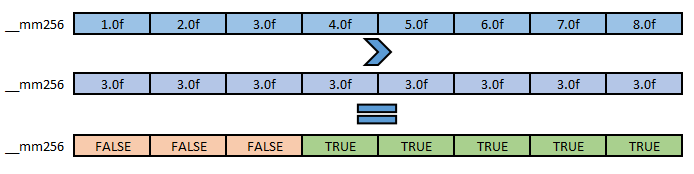


As entradas são dois vetores com valores float. A saída dessa operação lógica, também é um vetor de valores float, mas os valores devem ter somente bits 0's ou somente bits 1's. Todos os 1's representam o valor lógico **`TRUE`**, enquanto os 0's são o valor lógico **`FALSE`**. O valor 1's é impresso como **`-nan`** para floats, ou como -1 para inteiros. O valor real armazenado não é importante, somente é necessário saber que possui valores verdadeiros (**`TRUE`**) ou valores falsos (**`FALSE`**).

Resultado dos operadores lógicos (>, <, ==, &&, ||, etc)

Utilizando o operador && como um exemplo:

* **`vector && vector`** = **`mask`**
* **`mask && mask`** = **`mask`**
* **`vector && mask`** = **`?????`**

Eu ainda não testei o último caso, eu acho que retornará resultados inesperados. É como realizar **`3 > false`**, talvez em C++ funcione, mas no aspecto lógico, é incorreto.

> NOTA: Diferentemente dos valores booleanos, em que qualquer valor diferente de zero é TRUE. Somente um vetor composto com todos os bits 1's é considerado TRUE. Não utilize outros valores como máscara, pois falhará ou retornará resultados inesperados.


###Carregamento Condicional

Máscaras podem ser utilizadas para carregar condicionalmente valores em vetores. Se você relembrar as funções blend-based. Todas elas utilizam máscaras para controlar condicionalmente o carregamento de valores nos vetores: **`if_select(mask,value_true,value_false)`** pode ser representado como:

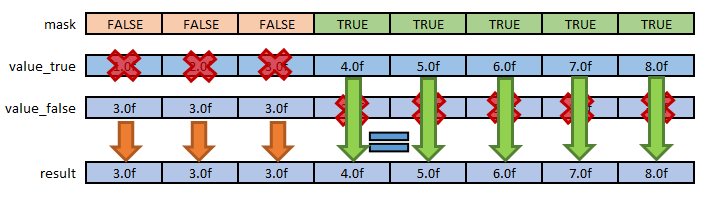

Quando a máscara é definida como FALSE, o dado é carregado do vetor value_false, e quando é TRUE, o dado vem do vetor value_true. O conceito é simples, mas efetivo.

No próximo exercício, você precisa carregar um vetor de acordo com as seguintes condições:

```
if (value > 3.0f || (value <= -3.7f && value > -15.0f)) {
   return sqrt(2.0f * value + 1.5f);
 }
 else {
   return (-2.0f * value - 8.7f);
 }

```

@[Masked load]({"stubs": ["masked/masked.cpp","masked/v8f.h"], "command": "./mycompile.sh masked ./masked"})

> NOTA: **`if_select`** NÃO É um nome de função intrínseca. É o meu wrapper para **`_mm256_blendv_ps`**. Por favor, note que **`_mm256_blendv_ps`** possui uma ordem de parâmetros bem diferente! blendv tem a máscara como o último parâmetro!

###Desempenho
Carregamento condicional utilizando máscaras não são uma branch real, então não possuem previsões errôneas, dessa forma a CPU pode fazer melhor uso da execução fora de ordem. Mas isso vem com um preço. Como vem sem uma branch, e toda a execução condicional é feita com operação em máscaras, ambas as branches são sempre calculadas e executadas.

Se você tiver um cálculo complexo para o **`value_false`**, ele será sempre calculado, mesmo que ele aconteça em 0,00001% das vezes. Isso acarreta em problemas de desempenho se tiver partes do código que são realmente necessárias, mas computacionalmente caras.

Na próxima lição, nós iremos aprender algumas formas de controlar o fluxo de dados, sendo capazes de sair de laçoes baseado em algumas condições.


##Controlando o fluxo de dados

###A questão do fluxo de dado compartilhado

Em programação linear, não existem problemas com a criação de divisões condicionais (funções como **`if, switch, continue e break`**) para o controle do fluxo de dados. Você pode simplesmente ter um loop infinito e bloquear sua execução quando a condição for satisfeita. Mas, como visto na lição anterior, um vetor não tem somente um resultado, mas N resultados no mesmo instante. Ainda, parte de um vetor pode estar pronta para sair do loop (por conta dos dados no vetor satisfazerem a condição de saida), e parte ainda estar sendo processada antes de finalizar sua execução.

> NOTA: Se um elemento do vetor estiver finalizado, congele seu processamento para evitar gasto de processamento inútil. Isso é feito através de uma máscara de componentes finalizados. Os elementos não finalizados, seguiram com a atualização, e os finalizados não. Assim, suponhamos um vetor de 8 posições, e os elementos 0, 1, 4 e 7 já foram processados, teremos então uma máscara [**`false,false,true,true,false,true,true,false`**] que armazena o estado de cada elemento.

###Evitando a execução de ramificações computacionalmente custosas

Uma boa abordagem para otimizar o tempo de CPU é checando se todos os valores na máscara são o mesmo, todos **`TRUE`** ou **`FALSE`**. Quando todos os valores na máscara são os mesmos, temos um simples booleano, verdadeiro ou falso. Este pode ser utilizado para avançar em partes do código, ou usar desvios condicionais tradicionais: **`if, switch, continue e break`**...

Nas minhas classes empacotadas, uso a função **`horizontal_or (mask)`** (que empacota intrínsecos **`_xxx_testz_xx`**). "Horizontal_OR" verifica se algum valor na máscara é **`true`** , e neste caso retorna um simples valor booleano, e **`false`** em caso contrário

O próximo exercício apresenta alguns problemas de tempo limite devido a uma função computacionalmente intensiva, necessária apenas em alguns casos específicos. Otimize o código para evitar o tempo limite:

@[Skipping Code Execution]({"stubs": ["skip/skip.cpp","skip/v8f.h"], "command": "./mycompile.sh skip ./skip"})

###Controlando o fluxo de dados

Utilizando **`horizontal_or`**, você pode interromper o loop antes. Não é possível conseguir essa otimização com autovetorização, mas com a vetorização manual é possível e preferível.

Neste exercício, será calculado uma pontuação máxima entre 8 simulações paralelas ao mesmo tempo, com um limite de 200 rodadas. Deseja-se finalizar a simulação quando atingir uma pontuação maior que 1700 pontos em qualquer uma das simulações, e retornar o valor máximo (um ponto flutuante, não todo o vetor de pontuação, somente o máximo) e a rodada que se atingiu este valor.

@[Early exiting a loop]({"stubs": ["exitloop/exitloop.cpp","exitloop/v8f.h"], "command": "./mycompile.sh exitloop ./exitloop"})



##Palavras finais

Neste curso, você deve ter obtido um bom nível de compreensão sobre vetorização manual e automática de CPU:

* Requisitos de Hardware e software para usar instruções SSE e AVX no seu código.
* Os tipos de dados de vetores disponíveis.
* Informação sobre como checar o uso de autovetorização e dicas se loopes podem ser autovetorizados.
* Frameworks de vetores em C++.
* Mascaramento e carga condicional.
* Controle do fluxo de dados.

###Prós e contras

As vetorizações AVX e SSE são interessantes e, teoricamente, seu uso traz mais benefícios que qualquer otimização linear.

**Prós**

* Ganhos potenciais de 300% a 600% de performance quando comparados a código linear.
* Similaridades com CUDA, programação vetorizada no nível de GPU.

**Contras**


* A performance depende do hardware em que o código está sendo rodado.
* Má performance quando há muito carregamento e descarregamento de dados.
* O fluxo de dados pode se tornar bem difícil de controlar, e o tempo de execução de cada valor dentro do vetor afeta o tempo de execução geral. Você não pode sair antes que todos os valores satisfaçam a condição de saída.
* É complexo para programar.
* Carece de funções instrínsecas: Trigonometria, números aleatórios, divisão de inteiros.

###Outros cursos

Em desenvolvimento: Offline MarsLander solver using a Genetic Algorithm (AVX enabled)/

###Jogos Multiplayer Codingame

Simulações com uso de AVX podem ser feitas em alguns Jogos Multiplayer Codingame:

* https://www.codingame.com/multiplayer/bot-programming/coders-strike-back  Minha versão do AVX alcançou entre 2.5 e 3.5 milhões de simulações por turno, com turnos de 150 milisegundos. Isso é feito paralelizando 8 simulações de estadoos jo jogo ao mesmo tempo. Uma versão anterior com cálculos seriais (isto é, com dados fora do AVX, colocando-os dentro de vetores AVX, calculando e, depois, retirando o resultado) alcançou apenas 600k simulações/turno.
* https://www.codingame.com/multiplayer/bot-programming/poker-chip-race  Performance é bem dependente do número de indivíduos, entre 100k e 1.5M simulações/turno. Os turnos duram 150ms também.

Vários outros jogos podem ser paralelizados e simulados usando vetores AVX/SSE.

###Links úteis

* https://software.intel.com/sites/landingpage/IntrinsicsGuide 

* https://db.in.tum.de/~finis/x86-intrin-cheatsheet-v2.2.pdf?lang=en

* http://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-software-developer-vol-1-manual.pdf

* http://www.agner.org/optimize/

##Como executar os programas em c/c++

1 - Para executar os códigos em C/C++ é preciso adicionar o comando especial **`%%writefile`** e o nome do arquivo para salvá-lo

In [1]:
%%writefile autovector.cpp

#pragma GCC optimize("O3","unroll-loops","omit-frame-pointer","inline") //Optimization flags
#pragma GCC option("arch=native","tune=native","no-zero-upper") //Enable AVX
#pragma GCC target("avx")  //Enable AVX
#include <x86intrin.h> //AVX/SSE Extensions
#include <bits/stdc++.h> //All main STD libraries

using namespace std;
using namespace std::chrono;

int main()
{
	const int N = 200000; //Array Size
	const int noTests = 10000; //Number of tests
	float a[N],b[N],c[N],result[N];
    auto now = high_resolution_clock::now();
    for (int i = 0; i < N; ++i)  //Data initialization	
	{ 
      a[i] =       ((float)i)+ 0.1335f; 
	  b[i] = 1.50f*((float)i)+ 0.9383f; 
	  c[i] = 0.33f*((float)i)+ 0.1172f; 
    }    
   for (int i = 0; i < noTests; ++i) 
	 for (int j = 0; j < N; ++j)
	 {
	  result[j] = a[j]+b[j]-c[j]+3*(float)i;
	 }
	auto end_time = duration_cast<duration<double>>(high_resolution_clock::now() - now).count();
	assert( result[2] == ( 2.0f + 0.1335f)+( 1.50f*2.0f + 0.9383f)-(0.33f*2.0f+0.1172f)+3*(float)(noTests-1));
    cout << "CG> message -channel \"exercise results\" Time used: "<< end_time << "s, N * noTests="<<(N*noTests)<< endl;
    return 0;
}

Writing autovector.cpp


2- Salvado o arquivo é preciso dar o comando especial **`%%shell`**
seguido do comando para criar o executável 
```
%%shell
g++ nome_do arquivo.cpp -o nome_do_arquivo
./nome_do_arquivo
```

In [2]:
%%shell 
g++ autovector.cpp -o autovector 
./autovector 

CG> message -channel "exercise results" Time used: 1.09973s, N * noTests=2000000000


É preciso se atentar para mudar o caminho de endereço dos cabeçahos (arquivos .h) 

In [10]:
%%writefile  exitloop.cpp

#pragma GCC optimize("O3","unroll-loops","omit-frame-pointer","inline") //Optimization flags
#pragma GCC option("arch=native","tune=native","no-zeroupper") //Enable AVX
#pragma GCC target("avx") //Enable AVX
#include <x86intrin.h>    //AVX/SSE Extensions
#include <bits/stdc++.h>  //All main STD libraries
//# Foi preciso mudar o caminho até o arquivo .h
#include "playground-41d1904q/projects/avx/exitloop/v8f.h"        //SSE 8x short vectors
using namespace std;

int validateResult(const int& turn,const float& bestScore)
{
 cout << "Turn:"<<turn<<"  bestScore:"<< std::setprecision(10)<<bestScore<<endl;
 if (turn != 133)
 {
     cout << "ERROR, Expected turn exit at 133 != "<<turn<<endl;
     return -1;
 }
 if (bestScore != 1707.318481f)
 {
     cout << "ERROR, Expected a bestScore of 1707.318481f != "<< std::setprecision(10)<<bestScore<<endl;
     return -1;
 }
 return 0;
}

int main()
{
    int turn = 0;
    v8f Scores(1.0f,3.0f,7.0f,13.4f,22.7f,0.01f,4.556f,9.7f); //Initial load
    for (turn =0; turn < 200; ++turn)
    {
        Scores += ((float)(turn)/15.0f);
        if ( turn == 40)  { Scores *= Scores/15.0f+2.0f;}
        if ( turn == 70)  { Scores += if_select(Scores < 430.0f, 850.0f, 120.0f );  }
        //EXERCISE: BREAK THE LOOP ONCE YOU REACH MORE THAN 1700 POINTS
     
    }
    cout << "Scores: "<<Scores<<endl;    
    float bestScore = 0.0f;
    //TODO:LOAD THE bestScore
	
    return validateResult(turn,bestScore);
}

Overwriting exitloop.cpp


In [ ]:
%%shell 
g++ exitloop.cpp -o exitloop
./exitloop

A compilação neste caso está funcionando, falta agora alterar o código para atender a função de validação.
Isso é com vocês :) 